<a href="https://colab.research.google.com/github/NeuroLife77/BIOL309_final_project/blob/main/biol309_2d_bifurcations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This cell is the "setup" so run it but don't worry about what's inside
To run a cell you can click on the play button at the top left of the cell (or click anywhere inside the cell and use the shortcut ctrl+enter)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from scipy.signal import periodogram
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/ColabNotebooks/biol_309')
# Heun integration scheme accelerated by numba
@numba.njit
def simulate_heun(fn, x0, parameters, dt = 0.1, length = 8.0, transient_removed = 4.0):
  # Default is 8sec simulation at 0.1ms step size, removing the first 4 sec
  num_steps = int(length*1000/dt)
  num_transient = int(transient_removed*1000/dt)
  # Setting up the array to collect the time points
  time_series = np.zeros((num_steps+1,3,parameters.shape[1]))
  # Set up initial conditions
  time_series[0]+= x0.reshape(3,1)
  # Forward steps
  for i in range(num_steps):
    time_series[i+1] = fn(time_series[i],parameters)*dt
    time_series_temp = time_series[i]+time_series[i+1]
    time_series_corr = fn(time_series_temp,parameters)*dt
    time_series[i+1] = time_series[i] + (time_series[i+1]+time_series_corr)/2 
  # Return the time series (minus transients)
  return time_series[num_transient:,:,:]

# Model equations
@numba.njit
def sigI(z):
  return 1/(1+np.exp(-2*(z-3.7)))
@numba.njit
def sigE(z,M,cm):
  return 1/(1+np.exp(-1.3*(z-4*(1-cm*M))))
@numba.njit
def Edot(E, I, M, cee,cei,taue,cm):
  return 1/taue * (-E+(1-E)*(sigE(cee*E-cei*I+1.25,M,cm)))
@numba.njit
def Mdot(E,M, taum,E_max):
  return (-M + (1-M)*(E_max-E))/taum 
@numba.njit
def Idot(E,I,cie,cii,taui):
  return 1/taui * (-I+(1-I)*(sigI(cie*E-cii*I)))
# Wrapper for integration function call
@numba.njit
def fn(state_var,parameters):
  E, I, M = state_var[0],state_var[1], state_var[2]
  cee, cei, cie, cii = parameters[0], parameters[1], parameters[2], parameters[3]
  taue, taui = parameters[4], parameters[5]
  cm, taum, E_max = parameters[6], parameters[7], parameters[8]
  output = np.zeros_like(state_var)
  output[0] = Edot(E, I, M, cee, cei, taue, cm)
  output[1] = Idot(E, I, cie, cii, taui)
  output[2] = Mdot(E, M, taum, E_max)
  return output

# Global variables to keep track of things 
# Also allows easy interface and automated adaptive plots for non-coders in the group
parameter_indices = { "cee":0,"cei":1,"cie":2,"cii":3,"taue":4,"taui":5,"cm":6,"taum":7,"E_max":8}
latex = {"cee":"$c_{ee}$", "cei":"$c_{ei}$", "cie":"$c_{ie}$","cii":"$c_{ii}$","taue":"$\\tau_{e}$", "taui":"$\\tau_{i}$","cm":"$c_{m}$","taum":"$\\tau_{m}$", "E_max":"$E_{max}$",}

# Interface to obtain the time series from the dictionary of parameter values
def get_simulation(parameter_dict, initial_cond = [0.5,0.5,0.5], **kwargs):
  M_parameters = np.array([
    parameter_dict[item] for item in parameter_dict
  ])
  ts = simulate_heun(fn,np.array(initial_cond),M_parameters, **kwargs)
  return ts

# Function to produce the data for 2D bifurcation plots from the dictionary interface
def get_bifurcation2D(parameter_dict, bifurcations_settings, IC_list = np.array([[0.8,0.2,0.0],[0.2,0.8,0.5]]), **settings):
  # Set up the simulation parameters using the dictionaries
  M_parameters = np.array([
        parameter_dict[item] for item in parameter_dict
    ])
  bif0_par = parameter_indices[bifurcations_settings[0]["bifurcation_parameter"]]
  bif1_par = parameter_indices[bifurcations_settings[1]["bifurcation_parameter"]]
  bif0_vals = np.linspace(
                              *bifurcations_settings[0]["bifurcation_range"],
                              bifurcations_settings[0]["bifurcation_resolution"]
                          )
  bif1_vals = np.linspace(
                              *bifurcations_settings[1]["bifurcation_range"],
                              bifurcations_settings[1]["bifurcation_resolution"]
                          )
  # Variable to collect the data
  bifurcation = np.zeros((bif1_vals.shape[0],bif0_vals.shape[0], IC_list.shape[0], 2, 3))
  frequency = np.zeros((bif1_vals.shape[0],bif0_vals.shape[0], IC_list.shape[0], 3, 100*4))
  # Iterate over all parameter values for the bifurcation
  all_params = np.zeros((bif1_vals.shape[0], bif0_vals.shape[0], M_parameters.shape[0]))
  for par_index, par0_val in enumerate(bif0_vals):
    M_parameters[bif0_par]=par0_val
    for par_index_inner, par1_val in enumerate(bif1_vals):
      M_parameters[bif1_par]=par1_val
      all_params[par_index_inner, par_index] = M_parameters.copy()
  for par_index, par1_val in enumerate(bif1_vals):
    for i, IC in enumerate(IC_list):
      # Simulate
      # Keep the min and max of the time series
      ts = np.transpose(simulate_heun(fn, IC, all_params[par_index].T, **settings),axes=(2,1,0))
      bifurcation[par_index, :, i,0,:] = ts.min(-1)
      bifurcation[par_index, :, i,1,:] = ts.max(-1)
      # Compute the PSD of the time series (Only up to 40Hz)
      freq, power = periodogram(ts,fs = 10000, axis=-1)
      # Normalize the power to 0-1 range
      power /= power.max(-1, keepdims=True) + 1e-10
      # Keep only the first 100Hz
      frequency[par_index, :, i, 0] = power[:, 0,:100*4]
      frequency[par_index, :, i, 1] = power[:, 1,:100*4]
      frequency[par_index, :, i, 2] = power[:, 2,:100*4]
          
  # Collapse the 25 initial conditions with the min-max axis for easy plotting      
  bifurcation_E = bifurcation[:,:,:,:,0].reshape((bif1_vals.shape[0],bif0_vals.shape[0],2*len(IC_list)))
  bifurcation_I = bifurcation[:,:,:,:,1].reshape((bif1_vals.shape[0],bif0_vals.shape[0],2*len(IC_list)))
  bifurcation_M = bifurcation[:,:,:,:,2].reshape((bif1_vals.shape[0],bif0_vals.shape[0],2*len(IC_list)))

  # Return all necessary values
  return bifurcation_E, bifurcation_I, bifurcation_M, [bif0_vals,bif1_vals], frequency, IC_list

parameter_range_dict = {
    "cee":[11, 16],
    "cei":[5, 15],
    "cie":[8, 12],
    "cii":[5, 10],
    "taue":[1, 50],
    "taui":[1, 50],
}
from pickle import dump, load
def save_log(log, directory, file_name, enforce_replace = False):
    try:
        with open(f'{directory}/{file_name}.pkl', 'rb') as f:
            _ = load(f)
        if not enforce_replace:
            print("This file already exists, please select 'enforce_replace = True' to rewrite it.")
            return
    except:
        pass
    with open(f'{directory}{file_name}.pkl', 'wb') as f:
        dump(log, f)

def get_log(directory, file_name):
    if directory is None and 'drffit_object' in file_name:
        return None
    try:
        with open(f'{directory}{file_name}.pkl', 'rb') as f:
            log = load(f)
        return log
    except:
        print(f"File '{directory}{file_name}.pkl' does not exist.")
        return None

Mounted at /content/gdrive/


## This is where you start using things

The "parameter_dict" variable contains the values of the parameters for the model that are fixed. Change them to specify the model's "fixed" parameters if necessary.

The "bifurcation_settings" variable contains the information to make the bifurcation plots:
- "bifurcation_parameter" is the name of the parameter you want to use for the bifurcation, it should be exactly the same as in "parameter_dict", so just copy/paste the name from it.
- "bifurcation_range" is a list of [min, max] values for the bifurcation parameter.
- "bifurcation_resolution" is how many points are used to draw the bifurcation diagram.

**PS: I suggest that you start with the whole range for your parameter and see what range has interesting behavior (around a bifurcation), then come back at this cell and run the tests again with the smaller range (and perhaps higher resolution).**

In [ ]:
# Run the cell to get the data for the bifurcation plot
save = False

# Change the the parameter_dict to fix parameter values
parameter_dict = {
    "cee":16,    # [11, 16]
    "cei":15,    # [2, 15]
    "cie":12,    # [2, 22]
    "cii":3,     # [2, 15]
    "taue":8,    # [1, 50]
    "taui":25,   # [1, 50]
    "cm":1.0,    # [0, 1] fixed don't change (will be automatically changed)
    "taum":100,  # fixed don't change
    "E_max":0.5  # [0, 1] fixed don't change (not used in the tests here)
}
parameters_to_test = ["cee, cie"]
for key in parameters_to_test:
  # Chose the parameter that you want to vary, and define the range & resolution of the bifurcation diagram 
  bifurcation_settings = [
      {
        "bifurcation_parameter":key,
        "bifurcation_range":parameter_range_dict[key],  # [min_val, max_val]
        "bifurcation_resolution":500     # Note: A resolution of 250 takes ~1min 5sec to run
      },
      {
        "bifurcation_parameter":"cm",
        "bifurcation_range":[0, 1.0],  # [min_val, max_val]
        "bifurcation_resolution":100   # Note: A resolution of 250 takes ~1min 5sec to run
      }
  ]
  # This runs the test with the original model (with modulatory input OFF)
  bifurcation_E, bifurcation_I, bifurcation_M, parameter_range, frequency, IC_list = get_bifurcation2D(parameter_dict, bifurcation_settings, length = 8.0, transient_removed = 4.0)
  # Setting up stuff to allow the plots to show initial condition values in the title
  bifurcation_dict = {
      "bifurcation_E": bifurcation_E,
      "bifurcation_I": bifurcation_I, 
      "bifurcation_M": bifurcation_M, 
      "parameter_range": parameter_range, 
      "frequency": frequency, 
      "IC_list": IC_list
  }
  if save:
    save_log(bifurcation_dict, '/content/gdrive/MyDrive/Colab Notebooks/biol_309/',f'bifurcation2D_{key}')
initial_cond_list = []
for IC in IC_list:
  initial_cond_list.append([f"$E_0={round(IC[0],2)}$", f"$I_0={round(IC[1],2)}$", f"$M_0={round(IC[2],2)}$"])

In [ ]:
bif_inX, bif_inY = np.meshgrid(parameter_range[0],parameter_range[1])
from mpl_toolkits import mplot3d
par_latex0 = latex[bifurcation_settings[0]["bifurcation_parameter"]]
par_latex1 = latex[bifurcation_settings[1]["bifurcation_parameter"]]
num_angles = 4
fig = plt.figure(figsize=(20,6*num_angles))
angle_axes = [[None,None,None] for _ in range(num_angles)]
list_angle_vals = [0,45,90,135]
ic_num = 1
colors = ["b","r"]
for angle in range(num_angles):
  angle_axes[angle][0] = plt.subplot(num_angles,3,1+(3*angle),projection='3d')
  for i in range(2*ic_num,2*(ic_num+1)):
      angle_axes[angle][0].plot_wireframe(bif_inX, bif_inY, bifurcation_E[:,:,i], color = colors[(i%2)])
  angle_axes[angle][0].set_xlabel(f'{par_latex0}')
  angle_axes[angle][0].set_ylabel(f'{par_latex1}')
  angle_axes[angle][0].set_zlabel('E');

  angle_axes[angle][1] = plt.subplot(num_angles,3,2+(3*angle),projection='3d')
  for i in range(2*ic_num,2*(ic_num+1)):
      angle_axes[angle][1].plot_wireframe(bif_inX, bif_inY, bifurcation_I[:,:,i], color = colors[(i%2)])
  angle_axes[angle][1].set_xlabel(f'{par_latex0}')
  angle_axes[angle][1].set_ylabel(f'{par_latex1}')
  angle_axes[angle][1].set_zlabel('I');

  angle_axes[angle][2] = plt.subplot(num_angles,3,3+(3*angle),projection='3d')
  for i in range(2*ic_num,2*(ic_num+1)):
      angle_axes[angle][2].plot_wireframe(bif_inX, bif_inY, bifurcation_M[:,:,i], color = colors[(i%2)])
  angle_axes[angle][2].set_xlabel(f'{par_latex0}')
  angle_axes[angle][2].set_ylabel(f'{par_latex1}')
  angle_axes[angle][2].set_zlabel('M');
  angle_axes[angle][0].view_init(elev=10., azim=180+list_angle_vals[angle])
  angle_axes[angle][1].view_init(elev=10., azim=180+list_angle_vals[angle])
  angle_axes[angle][2].view_init(elev=10., azim=180+list_angle_vals[angle])
plt.tight_layout()
plt.show()

## This is to plot the bifurcation that you produced in the cell above

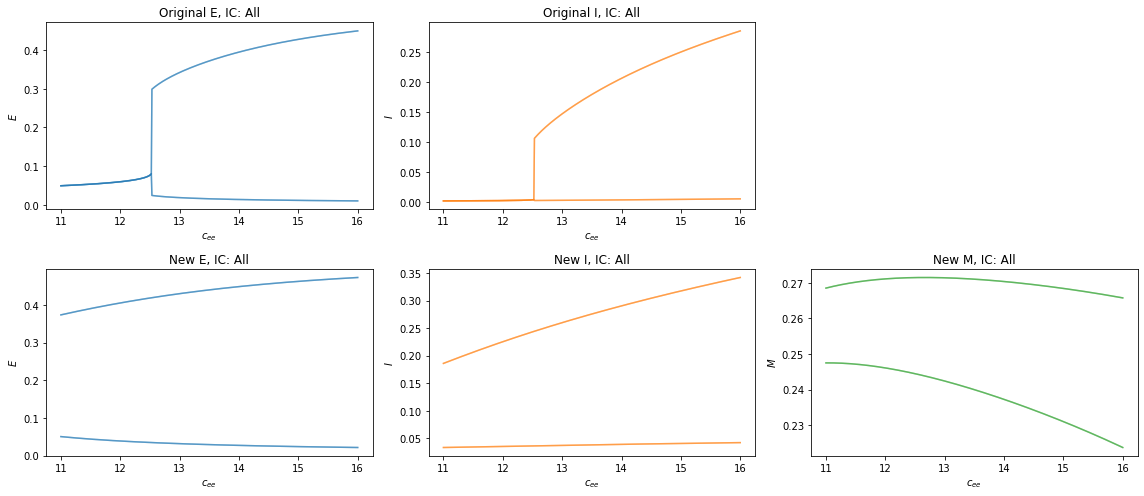

In [ ]:
# Run this cell after the one above to plot the bifurcations

par_latex = latex[bifurcation_settings[0]["bifurcation_parameter"]]
par_range = parameter_range[0].reshape((-1,1))
par_range0 = parameter_range[0].reshape((-1,1))
par_range1 = parameter_range[1].reshape((-1,1))
fig = plt.figure(figsize=(16,7))

# Make the plots for original model bifurcations
ax = plt.subplot(2,3,1)
ax.plot(par_range, bifurcation_E[0], 'C0', alpha=.5)
plt.title("Original E, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("$E$")
ax = plt.subplot(2,3,2)
ax.plot(par_range, bifurcation_I[0], 'C1', alpha=.5)
plt.title("Original I, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("$I$")

# Make the plots for new model bifurcations
ax = plt.subplot(2,3,4)
ax.plot(par_range, bifurcation_E[-1], 'C0', alpha=.5)
plt.title("New E, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("$E$")
ax = plt.subplot(2,3,5)
ax.plot(par_range, bifurcation_I[-1], 'C1', alpha=.5)
plt.title("New I, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("$I$")
ax = plt.subplot(2,3,6)
ax.plot(par_range, bifurcation_M[-1], 'C2', alpha=.5)
plt.title("New M, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("$M$")

plt.tight_layout()
plt.show()

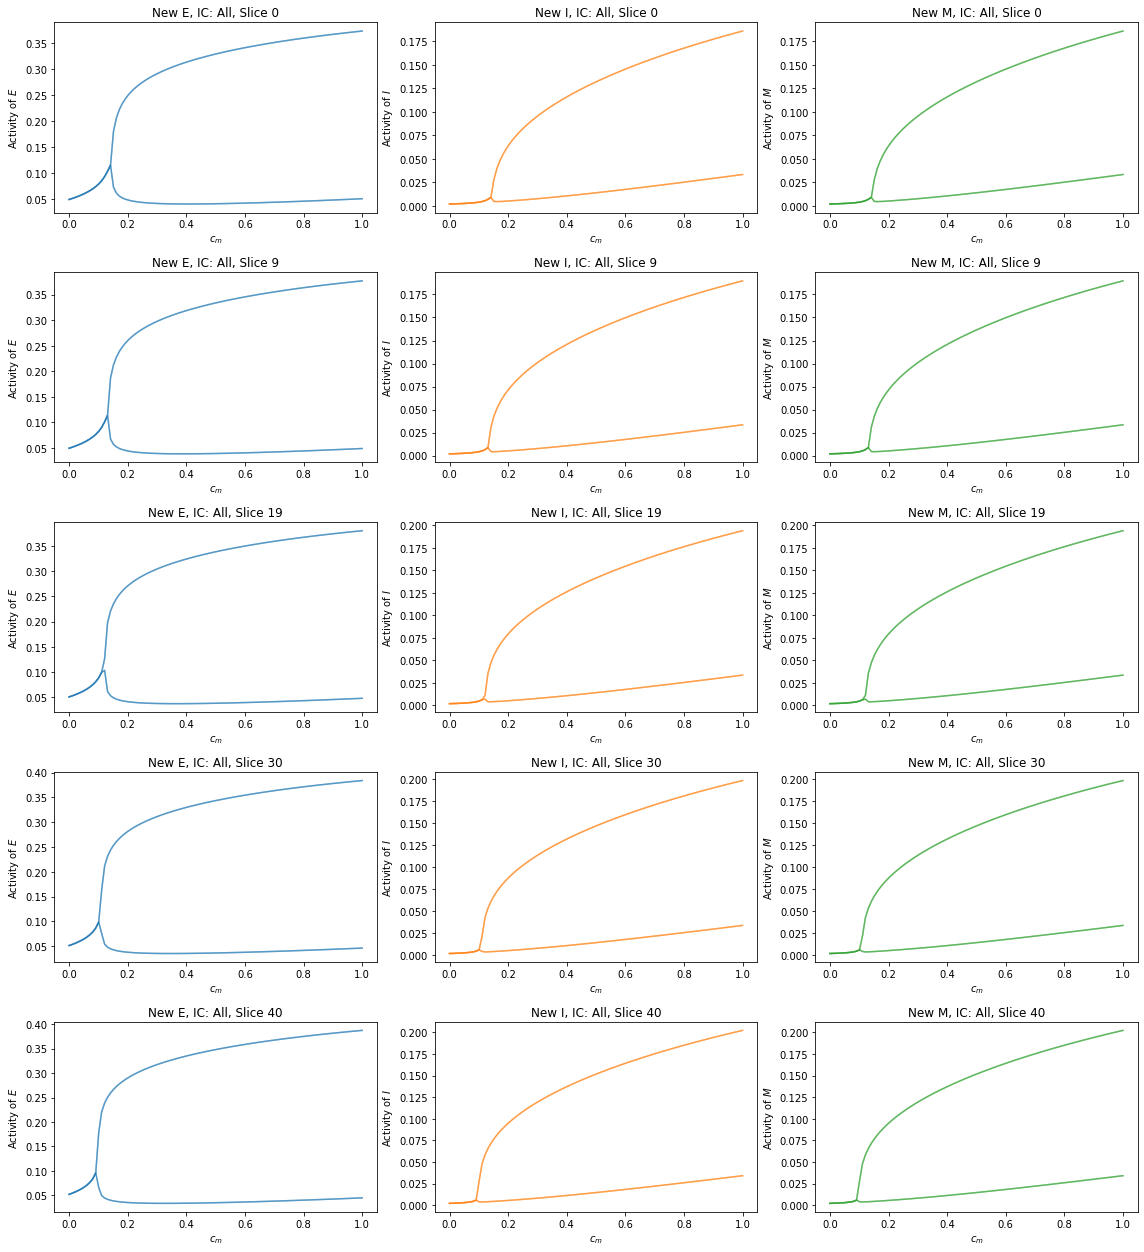

In [ ]:
values_to_slice_at = [11,11.1,11.2,11.3,11.4]

par2_val_indices = [int((val-bifurcation_settings[0]["bifurcation_range"][0])/(bifurcation_settings[0]["bifurcation_range"][1]-bifurcation_settings[0]["bifurcation_range"][0]) * bifurcation_settings[0]["bifurcation_resolution"]) for val in values_to_slice_at] 
fig = plt.figure(figsize=(16,3.5*len(par2_val_indices)))
for ct,par2_val_index in enumerate(par2_val_indices):
  ct *= 3
  # Make the plots for new model bifurcations
  ax = plt.subplot(len(par2_val_indices),3,1+ct)
  ax.plot(par_range1, bifurcation_E[:,par2_val_index], 'C0', alpha=.5)
  plt.title(f"New E, IC: All, Slice {par2_val_index}")
  plt.xlabel(f"{par_latex1}")
  plt.ylabel("Activity of $E$")
  ax = plt.subplot(len(par2_val_indices),3,2+ct)
  ax.plot(par_range1, bifurcation_I[:,par2_val_index], 'C1', alpha=.5)
  plt.title(f"New I, IC: All, Slice {par2_val_index}")
  plt.xlabel(f"{par_latex1}")
  plt.ylabel("Activity of $I$")
  ax = plt.subplot(len(par2_val_indices),3,3+ct)
  ax.plot(par_range1, bifurcation_I[:,par2_val_index], 'C2', alpha=.5)
  plt.title(f"New M, IC: All, Slice {par2_val_index}")
  plt.xlabel(f"{par_latex1}")
  plt.ylabel("Activity of $M$")
plt.tight_layout()
plt.show()

## This is to investigate the frequency of the time series
The cell above will tell you if there is a fixed point or a cycle, but it won't tell you what the cycle looks like. The cell below will plot the frequency of the cycle if there is one. A fixed point should have a frequency of 0.

*Note: The frequency is approximated on a small time window, this may create some slight variations with different initial conditions due to the phase lag, so unless the difference between the 2 initial conditions are fairly significant odds are they are just artifacts of the method.*

In [ ]:
# Run this cell to plot
bif_inX, bif_inY = np.meshgrid(parameter_range[0],parameter_range[1])
num_angles = 4
fig = plt.figure(figsize=(20,6*num_angles))
angle_axes = [[None,None,None] for _ in range(num_angles)]
list_angle_vals = [0,45,90,135]
ic_num = 1
for angle in range(num_angles):
  angle_axes[angle][0] = plt.subplot(num_angles,3,1+(3*angle),projection='3d')
  angle_axes[angle][0].scatter(bif_inX, bif_inY, frequency[:,:,ic_num,0].argmax(-1)/4, c=frequency[:,:,ic_num,0].argmax(-1)/4, cmap='viridis')
  angle_axes[angle][0].set_xlabel(f'{par_latex0}')
  angle_axes[angle][0].set_ylabel(f'{par_latex1}')
  angle_axes[angle][0].set_zlabel('E peak frequency');
  angle_axes[angle][1] = plt.subplot(num_angles,3,2+(3*angle),projection='3d')
  angle_axes[angle][1].scatter(bif_inX, bif_inY, frequency[:,:,ic_num,1].argmax(-1)/4, c=frequency[:,:,ic_num,1].argmax(-1)/4, cmap='viridis')
  angle_axes[angle][1].set_xlabel(f'{par_latex0}')
  angle_axes[angle][1].set_ylabel(f'{par_latex1}')
  angle_axes[angle][1].set_zlabel('I peak frequency');
  angle_axes[angle][2] = plt.subplot(num_angles,3,3+(3*angle),projection='3d')
  angle_axes[angle][2].scatter(bif_inX, bif_inY, frequency[:,:,ic_num,2].argmax(-1)/4, c=frequency[:,:,ic_num,2].argmax(-1)/4, cmap='viridis')
  angle_axes[angle][2].set_xlabel(f'{par_latex0}')
  angle_axes[angle][2].set_ylabel(f'{par_latex1}')
  angle_axes[angle][2].set_zlabel('M peak frequency');
  angle_axes[angle][0].view_init(elev=10., azim=180+list_angle_vals[angle])
  angle_axes[angle][1].view_init(elev=10., azim=180+list_angle_vals[angle])
  angle_axes[angle][2].view_init(elev=10., azim=180+list_angle_vals[angle])
plt.tight_layout()
plt.show()

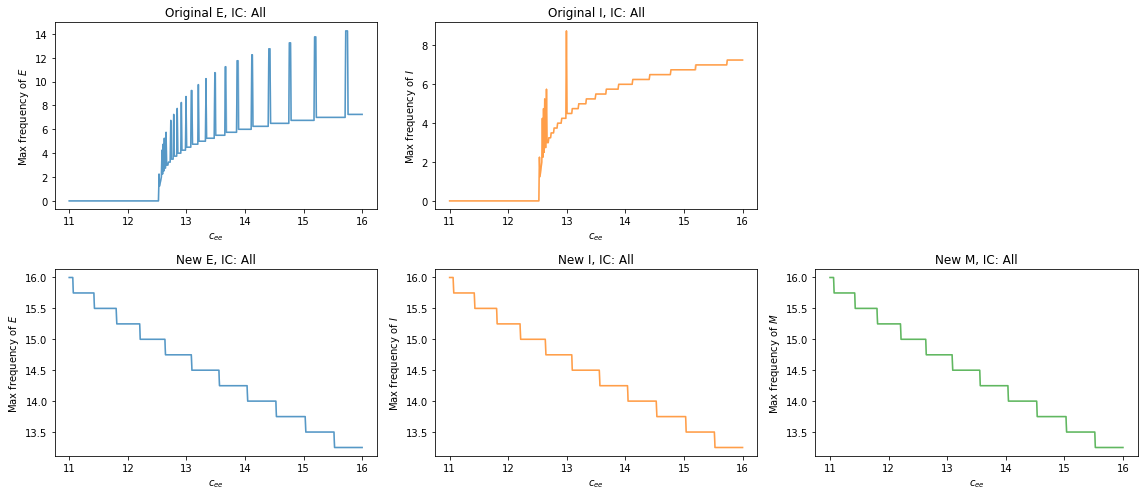

In [ ]:
fig = plt.figure(figsize=(16,7))
ic_num = 0
par2_val_index = -1 
# Make the plots for original model bifurcations
ax = plt.subplot(2,3,1)
ax.plot(par_range, frequency[0,:,:,0].argmax(-1)/4, 'C0', alpha=.5)
plt.title("Original E, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("Max frequency of $E$")
ax = plt.subplot(2,3,2)
ax.plot(par_range, frequency[0,:,:,1].argmax(-1)/4, 'C1', alpha=.5)
plt.title("Original I, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("Max frequency of $I$")

# Make the plots for new model bifurcations
ax = plt.subplot(2,3,4)
ax.plot(par_range, frequency[par2_val_index,:,:,0].argmax(-1)/4, 'C0', alpha=.5)
plt.title("New E, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("Max frequency of $E$")
ax = plt.subplot(2,3,5)
ax.plot(par_range, frequency[par2_val_index,:,:,1].argmax(-1)/4, 'C1', alpha=.5)
plt.title("New I, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("Max frequency of $I$")
ax = plt.subplot(2,3,6)
ax.plot(par_range, frequency[par2_val_index,:,:,2].argmax(-1)/4, 'C2', alpha=.5)
plt.title("New M, IC: All")
plt.xlabel(f"{par_latex}")
plt.ylabel("Max frequency of $M$")
plt.tight_layout()
plt.show()

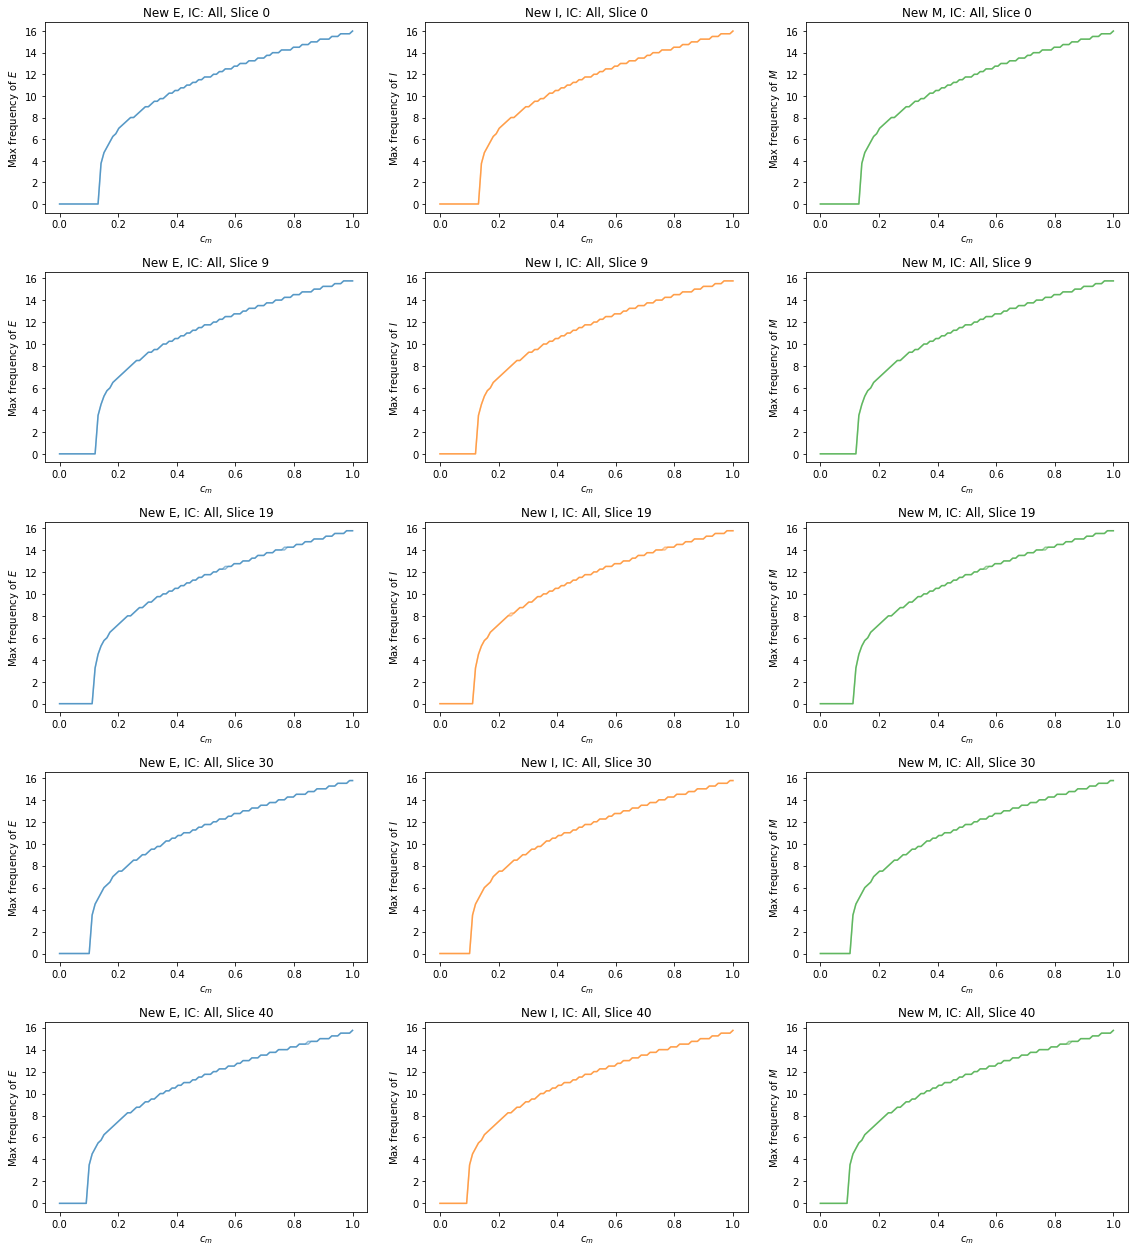

In [ ]:
#par2_val_indices = [int(3.1/7 * 1000),int(3.3/7 * 1000),int(3.5/7 * 1000),int(3.7/7 * 1000),int(3.9/7 * 1000)] 
fig = plt.figure(figsize=(16,3.5*len(par2_val_indices)))
for ct,par2_val_index in enumerate(par2_val_indices):
  ct *= 3
  # Make the plots for new model bifurcations
  ax = plt.subplot(len(par2_val_indices),3,1+ct)
  ax.plot(par_range1, frequency[:,par2_val_index,:,0].argmax(-1)/4, 'C0', alpha=.5)
  plt.title(f"New E, IC: All, Slice {par2_val_index}")
  plt.xlabel(f"{par_latex1}")
  plt.ylabel("Max frequency of $E$")
  ax = plt.subplot(len(par2_val_indices),3,2+ct)
  ax.plot(par_range1, frequency[:,par2_val_index,:,1].argmax(-1)/4, 'C1', alpha=.5)
  plt.title(f"New I, IC: All, Slice {par2_val_index}")
  plt.xlabel(f"{par_latex1}")
  plt.ylabel("Max frequency of $I$")
  ax = plt.subplot(len(par2_val_indices),3,3+ct)
  ax.plot(par_range1, frequency[:,par2_val_index,:,2].argmax(-1)/4, 'C2', alpha=.5)
  plt.title(f"New M, IC: All, Slice {par2_val_index}")
  plt.xlabel(f"{par_latex1}")
  plt.ylabel("Max frequency of $M$")
plt.tight_layout()
plt.show()

## To view the distribution of frequency representations
This cell plots the power spectrum of the time series, which represents the distribution of frequency representations in the stable dynamics of the system. The plots above represent the maximum frequency value, which should be the bright yellow value of the plots below. 
It is a heat map, so purple -> yellow means low -> high representation of the frequency set at the Y axis for each parameter values tested (X axis).
Note: The plots don't allow superposition of the 2 initial conditions, so they are shown separately.

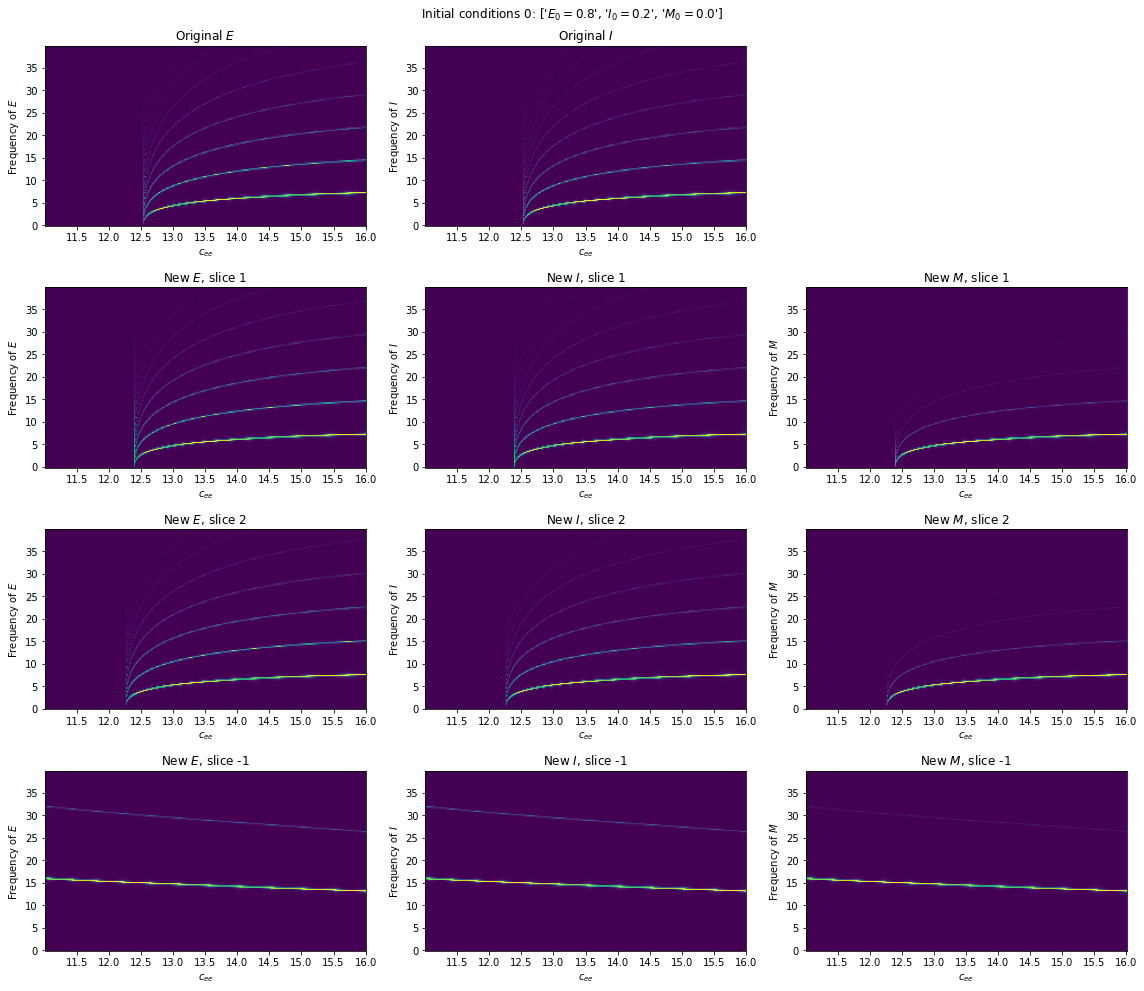

In [ ]:
# If you see that the Y axis has lots of empty space on the top, just reduce this value here
max_plot_freq = 40
par2_val_list = [1,2,-1] 
title = ["$E$","$I$","$M$"]
npoints = bifurcation_settings[0]["bifurcation_resolution"]
step_freq = max_plot_freq//8
for initial_cond in range(1):
  fig = plt.figure(figsize=(16,3.5*(len(par2_val_list)+1)))
  for j in range(2):
    ax = plt.subplot(1+len(par2_val_list),3,1+j)
    plt.imshow(frequency[0,:,initial_cond,j,:max_plot_freq*4].T, aspect = "auto")
    ax.invert_yaxis()
    ax.set_yticks([(4*step_freq)*i for i in range(8)])
    ax.set_yticklabels([f'{str(round(step_freq*i,0))}' for i in range(8)])
    ax.set_xticks([i for i in range(npoints//10-1,par_range.shape[0],npoints//10)])
    ax.set_xticklabels([f'{str(round(par_range[i].item(),1))}' for i in range(npoints//10-1,par_range.shape[0],npoints//10)])
    plt.ylabel(f"Frequency of {title[j]}")
    plt.xlabel(f"{par_latex}")
    plt.title(f"Original {title[j]}")
  for ct, par2_val_index in enumerate(par2_val_list):
    for j in range(3):
      ax = plt.subplot(1+len(par2_val_list),3,3*(ct+1)+(j+1))
      plt.imshow(frequency[par2_val_index,:,initial_cond,j,:max_plot_freq*4].T, aspect = "auto")
      ax.invert_yaxis()
      ax.set_yticks([(4*step_freq)*i for i in range(8)])
      ax.set_yticklabels([f'{str(round(step_freq*i,0))}' for i in range(8)])
      ax.set_xticks([i for i in range(npoints//10-1,par_range.shape[0],npoints//10)])
      ax.set_xticklabels([f'{str(round(par_range[i].item(),1))}' for i in range(npoints//10-1,par_range.shape[0],npoints//10)])
      plt.ylabel(f"Frequency of {title[j]}")
      plt.xlabel(f"{par_latex}")
      plt.title(f"New {title[j]}, slice {par2_val_index}")
  plt.tight_layout(rect=[0, 0.00, 1, 0.97])
  plt.suptitle(f"Initial conditions {initial_cond}: {initial_cond_list[initial_cond]}")
  plt.show()
  print()

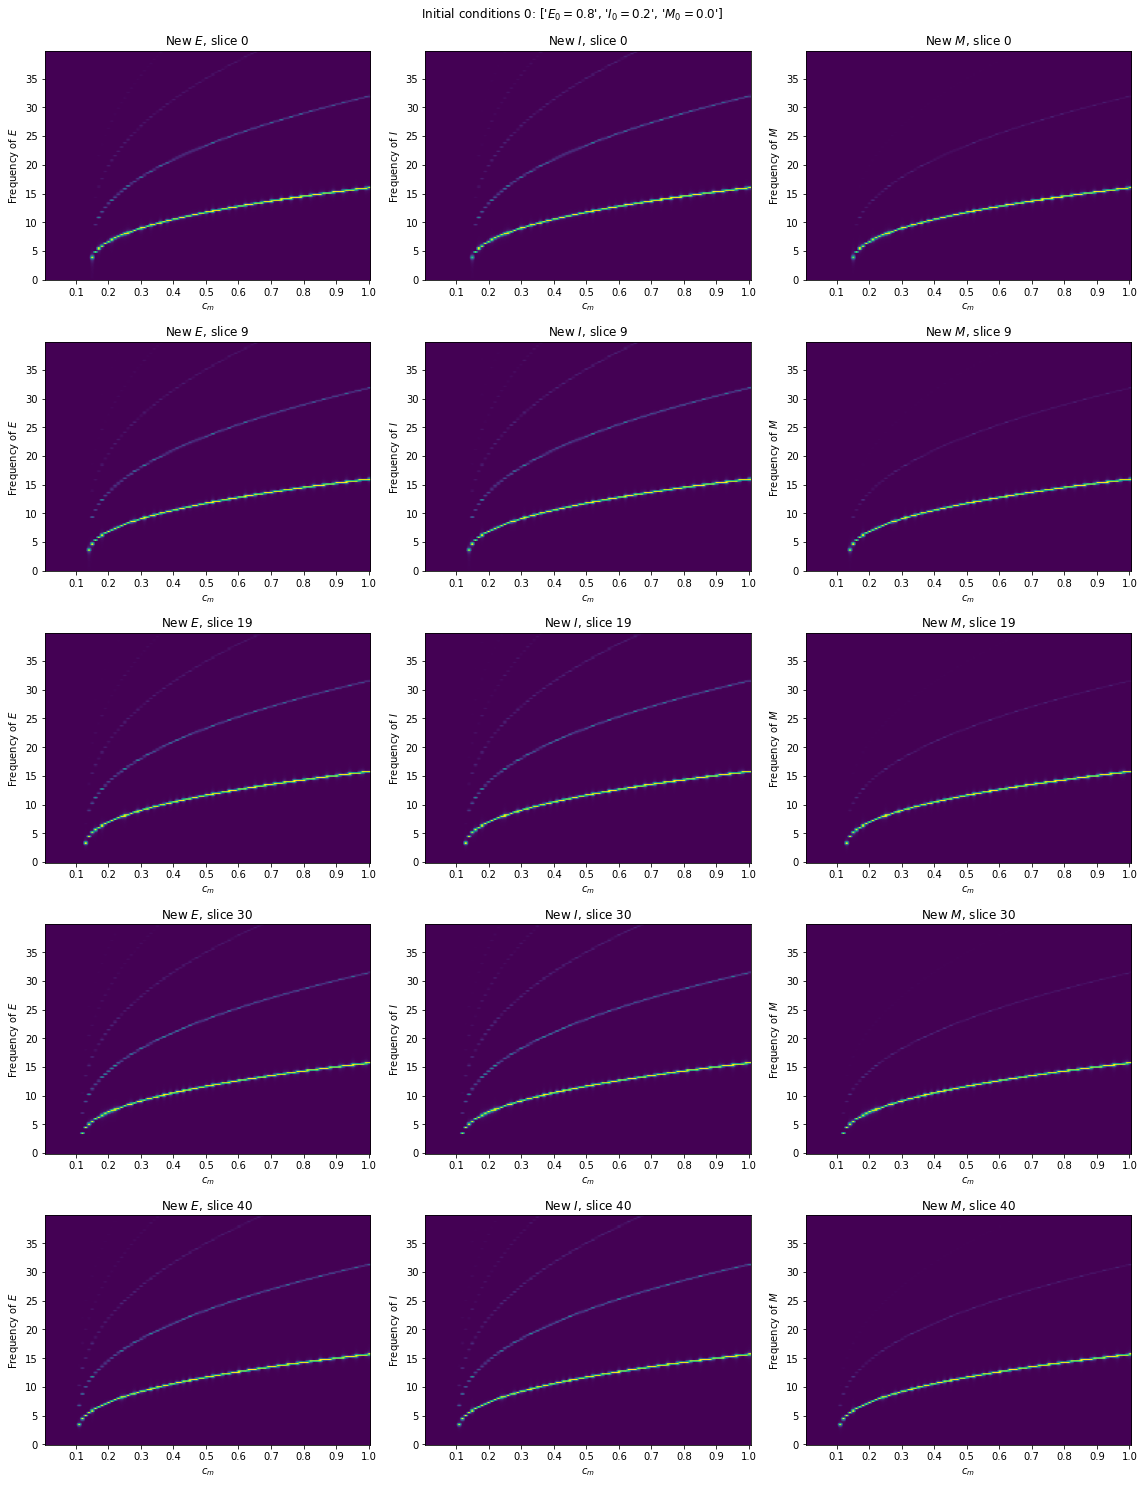

In [ ]:
# If you see that the Y axis has lots of empty space on the top, just reduce this value here
max_plot_freq = 40
#par2_val_list = [int((1.5+0.2*i)/3.6 * 100) for i in range(5)] 
title = ["$E$","$I$","$M$"]
npoints = bifurcation_settings[1]["bifurcation_resolution"]
step_freq = max_plot_freq//8
for initial_cond in range(1):
  fig = plt.figure(figsize=(16,3.5*(len(par2_val_indices)+1)))
  for ct, par2_val_index in enumerate(par2_val_indices):
    for j in range(3):
      ax = plt.subplot(len(par2_val_indices),3,3*(ct)+(j+1))
      plt.imshow(frequency[:,par2_val_index,initial_cond,j,:max_plot_freq*4].T, aspect = "auto")
      ax.invert_yaxis()
      ax.set_yticks([(4*step_freq)*i for i in range(8)])
      ax.set_yticklabels([f'{str(round(step_freq*i,0))}' for i in range(8)])
      ax.set_xticks([i for i in range(npoints//10-1,par_range1.shape[0],npoints//10)])
      ax.set_xticklabels([f'{str(round(par_range1[i].item(),1))}' for i in range(npoints//10-1,par_range1.shape[0],npoints//10)])
      plt.ylabel(f"Frequency of {title[j]}")
      plt.xlabel(f"{par_latex1}")
      plt.title(f"New {title[j]}, slice {par2_val_index}")
  plt.tight_layout(rect=[0, 0.00, 1, 0.97])
  plt.suptitle(f"Initial conditions {initial_cond}: {initial_cond_list[initial_cond]}")
  plt.show()
  print()

## If you want to see what happens at certain points of the bifurcation
Change the value of "parameter_value" below to the value of interest and run the cell. It will produce a time series that you will be able to plot in the later cell.

In [ ]:
# Write the value of interest here:
parameter_value = 6.4

# If you find that some bifurcation is different at specific initial conditions you can specify them here to see what happens
initial_cond = [0.75, 0.1, 0.0]

# This simulates with that specific value and returns the time series to plot in the cell below
parameter_dict[bifurcation_settings[0]["bifurcation_parameter"]] = par_interest = parameter_value
parameter_dict["cm"] = 0.0
ts0 = get_simulation(parameter_dict, initial_cond = initial_cond)
parameter_dict["cm"] = 1.0
ts1 = get_simulation(parameter_dict, initial_cond = initial_cond)

In [ ]:
# Run this cell to plot the time series of the state variables for the parameter value of interest

t = np.arange(int(2000/0.1))*0.1 + 4000

f = plt.figure(figsize=(18,8))

# Plot time series for the original model
ax = plt.subplot(2,1,1)
ax.plot(t,ts0[:20000,0], label = "E")
ax.plot(t,ts0[:20000,1], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.legend()
plt.title(f'Original model ($c_m = 0.0$), at {par_latex}$={par_interest}$')

# Plot time series for the new model
ax = plt.subplot(2,1,2)
ax.plot(t,ts1[:20000,0], label = "E")
ax.plot(t,ts1[:20000,1], label = "I")
ax.plot(t,ts1[:20000,2], label = "M")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.legend()
plt.title(f'New model ($c_m = 1.0$), at {par_latex}$={par_interest}$')

plt.tight_layout()
plt.show()

## Investigating sensitivity to initial conditions
If you find that you have multiple non-overlapping bifurcations then run this cell, it will plot the bifurcation diagram separately for all initial conditions.

This cell will show the results for the original model, and the one below will show the results for the new model (with $c_m = 1.0$) 

In [ ]:
# Run this cell to plot the 4 bifurcation diagrams (2 initial conditions as rows and 2 state variabes as columns)

# Separate the different initial conditions
bifurcation_E_separate_initial_conditions = bifurcation_E.reshape((parameter_range.shape[0],2,2))
bifurcation_I_separate_initial_conditions = bifurcation_I.reshape((parameter_range.shape[0],2,2))

fig = plt.figure(figsize=(15,4*2))
# Plot the bifurcation for each initial condition separately (each row is a different initial condition)
for i in range(2):
  ax = plt.subplot(2,2,1+2*i)
  ax.plot(par_range, bifurcation_E_separate_initial_conditions[:,i,:], 'C0', alpha=.75)
  plt.title(f"Original E, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$E$")
  ax = plt.subplot(2,2,2+2*i)
  ax.plot(par_range, bifurcation_I_separate_initial_conditions[:,i,:], 'C1', alpha=.75)
  plt.title(f"Original I, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$I$")
plt.tight_layout()
plt.show()

In [ ]:
# Run this cell to plot the 6 bifurcation diagrams (2 initial conditions as rows and 3 state variabes as columns)

# Separate the different initial conditions
bifurcation_E_cm_separate_initial_conditions = bifurcation_E_cm.reshape((parameter_range.shape[0],2,2))
bifurcation_I_cm_separate_initial_conditions = bifurcation_I_cm.reshape((parameter_range.shape[0],2,2))
bifurcation_M_cm_separate_initial_conditions = bifurcation_M_cm.reshape((parameter_range.shape[0],2,2))

fig = plt.figure(figsize=(18,3.5*2))
# Plot the bifurcation for each initial condition separately (each row is a different initial condition)
for i in range(2):
  ax = plt.subplot(2,3,1+3*i)
  ax.plot(par_range, bifurcation_E_cm_separate_initial_conditions[:,i,:], 'C0', alpha=.75)
  plt.title(f"New E, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$E$")
  ax = plt.subplot(2,3,2+3*i)
  ax.plot(par_range, bifurcation_I_cm_separate_initial_conditions[:,i,:], 'C1', alpha=.75)
  plt.title(f"New I, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$I$")
  ax = plt.subplot(2,3,3+3*i)
  ax.plot(par_range, bifurcation_M_cm_separate_initial_conditions[:,i,:], 'C2', alpha=.75)
  plt.title(f"New M, initial conditions: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("$M$")
plt.tight_layout()
plt.show()

## This is to investigate the frequency of the bifurcations
The same process as the 2 cells above, but showing the frequency instead of the min-max values.

In [ ]:
# Run this cell to plot the 4 bifurcation diagrams (2 initial conditions as rows and 2 state variabes as columns)

fig = plt.figure(figsize=(15,3.5*2))
# Plot the bifurcation for each initial condition separately (each row is a different initial condition)
for i in range(2):
  ax = plt.subplot(2,2,1+2*i)
  ax.plot(par_range, frequency[:,i,0].argmax(-1)/4, 'C0', alpha=.75)
  plt.title(f"Original E, IC: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Max frequency of $E$")
  ax = plt.subplot(2,2,2+2*i)
  ax.plot(par_range, frequency[:,i,1].argmax(-1)/4, 'C1', alpha=.75)
  plt.title(f"Original I, IC: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Max frequency of $I$")
  

plt.tight_layout()
plt.show()

In [ ]:
# Run this cell to plot the 6 bifurcation diagrams (2 initial conditions as rows and 3 state variabes as columns)

fig = plt.figure(figsize=(18,3.5*2))
# Plot the bifurcation for each initial condition separately (each row is a different initial condition)
for i in range(2):
  ax = plt.subplot(2,3,1+3*i)
  ax.plot(par_range, frequency_cm[:,i,0].argmax(-1)/4, 'C0', alpha=.75)
  plt.title(f"New E, IC: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Max frequency of $E$")
  ax = plt.subplot(2,3,2+3*i)
  ax.plot(par_range, frequency_cm[:,i,1].argmax(-1)/4, 'C1', alpha=.75)
  plt.title(f"New I, IC: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Max frequency of $I$")
  ax = plt.subplot(2,3,3+3*i)
  ax.plot(par_range, frequency_cm[:,i,2].argmax(-1)/4, 'C2', alpha=.75)
  plt.title(f"New M, IC: {initial_cond_list[i]}")
  plt.xlabel(f"{par_latex}")
  plt.ylabel("Max frequency of $M$")
plt.tight_layout()
plt.show()